# Imports

In [5]:
!pip install -q pandas numpy scipy matplotlib seaborn scikit-learn transformers accelerate \
    spacy sentence-transformers textblob sentencepiece fastcoref umap-learn openai

# spaCy model download
!python -m spacy download en_core_web_sm

# textblob corpora in case we decide to do sentiment tagging
!python -m textblob.download_corpora

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nl

In [3]:
import os
import re
import json
import pandas as pd
import numpy as np
import spacy
import umap.umap_ as umap
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from openai import OpenAI
from tqdm import tqdm

# Task 1: Context Extraction with Coreference Resolution

In [15]:
from fastcoref import spacy_component
nlp_sent = spacy.load("en_core_web_sm")
nlp_coref = spacy.load(
    "en_core_web_sm",
    exclude=["parser", "lemmatizer", "ner", "textcat"]
)
nlp_coref.add_pipe("fastcoref")

In [26]:
shooter_keywords = [
    "shooter", "gunman", "suspect", "attacker",
    "perpetrator", "killer", "opened fire",
    "active shooter", "armed"
]

victim_keywords = [
    "victim", "bystander", "person shot", "student shot", "civilian shot",
    "shot", "injured", "wounded", "fatality", "casualty",
    "dead", "killed", "passerby"
]

def contains_keyword(sentence, keywords):
    return any(k in sentence.lower() for k in keywords)

In [36]:
def extract_resolved_sentences(text, outlet, article_id):
    # Run coref and get resolved text
    doc_coref = nlp_coref(
        text,
        component_cfg={"fastcoref": {"resolve_text": True}}
    )
    resolved_text = doc_coref._.resolved_text

    # Now split resolved_text into sentences
    doc_resolved = nlp_sent(resolved_text)
    sentences = [s.text.strip() for s in doc_resolved.sents if s.text.strip()]

    rows = []

    outlet = article_id.split("_")[0].lower()
    for sent in sentences:
        is_shooter = contains_keyword(sent, shooter_keywords)
        is_victim  = contains_keyword(sent, victim_keywords)

        if not (is_shooter or is_victim):
            continue

        if is_shooter:
            rows.append({
                "outlet": outlet,
                "article_id": article_id.lower(),
                "entity_type": "shooter",
                "sentence": sent
            })

        if is_victim:
            rows.append({
                "outlet": outlet,
                "article_id": article_id.lower(),
                "entity_type": "victim",
                "sentence": sent
            })

    return rows

In [37]:
# sanity check - mock text generated by LLM
test_text = """
An 18-year-old man opened fire at a local mall. He shot two victims near the food court.
Police reported that the shooter fled the scene in a stolen car. The victims were taken to a nearby hospital.
"""

rows = extract_resolved_sentences(test_text, outlet="CNN", article_id="test")
pd.DataFrame(rows)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

,outlet,article_id,entity_type,sentence
0,test,test,shooter,An 18-year-old man opened fire at a local mall.
1,test,test,victim,An 18-year-old man shot two victims near the f...
2,test,test,victim,two victims were taken to a nearby hospital.


In [38]:
def run_task1(base_dir):
    all_rows = []
    outlets = ["cnn_five_para", "FOX_five_para", "NYT_five_para", "WSJ_five_para"]
    count = 0

    for outlet in outlets:
        folder = os.path.join(base_dir, outlet)
        for fname in os.listdir(folder):
            if not fname.lower().endswith(".txt"):
                continue

            article_id = fname.replace(".txt", "")
            fpath = os.path.join(folder, fname)

            with open(fpath, "r", encoding="utf-8", errors="replace") as f:
                text = f.read()

            rows = extract_resolved_sentences(text, outlet, article_id)
            all_rows.extend(rows)
            count += len(rows)

    print(f"Processed {count} sentences")

    df = pd.DataFrame(all_rows)
    df.to_csv("task1_coref_contexts.csv", index=False)
    return df

In [39]:
from google.colab import drive
drive.mount('/content/drive')

# Pull csv from google drive
base_dir = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/data_100"

df_task1 = run_task1(base_dir)
df_task1.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processed 324 sentences


,outlet,article_id,entity_type,sentence
0,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...
1,cnn,cnn_10_may25,victim,LIVE UPDATES: Deadly shooting at Texas element...
2,cnn,cnn_18_may25,victim,The National Rifle Association's annual meetin...
3,cnn,cnn_3_may24,victim,"An 18-year-old man is also dead, Gov. Greg Abb..."
4,cnn,cnn_3_may24,shooter,The Uvalde Consolidated Independent School Dis...


In [58]:
save_path = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task1_coref_contexts.csv"
df_task1.to_csv(save_path, index=False)

# Task 2: Description Extraction
Justify (expected strengths and limitations) your chosen approach(es) with a clear rationale (max 300 words)

LLM-based extraction was used to identify descriptive phrases for each entity because the language in news articles is highly variable and not always captured cleanly by rule based methods. Traditional parsing performs well for simple modifiers, but can miss multi-word expressions or contextual cues such as “engaged in a standoff” or “turn this pain into action.” Using an LLM like GPT allowed short, human interpretable phrases to be extracted directly without building custom heuristics or manually filtering noisy data. The model was prompted to return concise and descriptive strings with consistent formatting, which simplified clustering and manual interpretation in future steps. The approach was efficient and produced more stable semantic descriptors than rule-based extraction would provide.

In [ ]:
# in case you want to start from here
from google.colab import drive
drive.mount('/content/drive')

pth = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task1_coref_contexts.csv"
df_task1 = pd.read_csv(pth)

In [46]:
from openai import OpenAI

client = OpenAI(api_key="YOUR_KEY_HERE")

def llm_call(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",   # or "gpt-3.5-turbo" if cheaper
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )
    return response.choices[0].message.content


In [51]:
def extract_descriptions_llm(sentence, entity_type, llm_call):
    prompt = f"""
    Extract short descriptive phrases from the following resolved sentence
    that characterize the {entity_type}. The phrases should capture:
    - adjectives
    - short noun or verb phrases
    - actions
    - salient descriptive attributes

    Format:
    - return a JSON list of strings only
    - keep original wording
    - keep phrases short (2–6 words)
    - do NOT rewrite, summarize, or analyze
    - ignore irrelevant details
    - no backticks
    - no explanation
    - no markdown code blocks

    Sentence:
    "{sentence}"

    Output JSON list only:
    """
    return llm_call(prompt)


In [48]:
import json

def run_task2(df_task1, llm_call):
    task2_rows = []

    for _, row in tqdm(df_task1.iterrows()):
        sent = row['sentence']
        entity = row['entity_type']
        outlet = row['outlet']
        article_id = row['article_id']

        # LLM extraction
        raw = extract_descriptions_llm(sent, entity, llm_call)

        try:
            phrases = json.loads(raw)
        except:
            # if model adds commentary, re-prompt or strip text
            phrases = []

        for p in phrases:
            task2_rows.append({
                "outlet": outlet,
                "article_id": article_id,
                "entity_type": entity,
                "sentence": sent,
                "phrase": p
            })

    return pd.DataFrame(task2_rows)


In [53]:
# sanity check
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{
        "role": "user",
        "content": "Extract short descriptive phrases for the shooter from this sentence (NO MARKDOWN): 'An 18-year-old man opened fire in a crowded mall and then fled in a stolen car.' Return a JSON list only."
    }],
    temperature=0,
)

print("RAW OUTPUT:\n", json.loads(response.choices[0].message.content))


RAW OUTPUT:
 ['18-year-old man', 'opened fire', 'crowded mall', 'fled in a stolen car']


In [55]:
df_task2 = run_task2(df_task1, llm_call)
df_task2.head()

,outlet,article_id,entity_type,sentence,phrase
0,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,gunman
1,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,opened fire
2,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,stealing lives
3,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,devastating a nation
4,cnn,cnn_10_may25,victim,LIVE UPDATES: Deadly shooting at Texas element...,Deadly shooting


In [56]:
save_path = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task2_phrases.csv"
df_task2.to_csv(save_path, index=False)

In [ ]:
# def extract_sentiment_llm(sentence, entity_type, llm_complete):
#     prompt = f"""
#     Evaluate the sentiment tone toward the {entity_type} in this sentence.
#     Return a JSON dict:
#     {{
#         "polarity": "positive | neutral | negative",
#         "emotion": "fear | sorrow | anger | relief | neutral"
#     }}

#     Sentence:
#     "{sentence}"

#     Output:
#     """
#     return llm_complete(prompt)


# Task 3: Description Clustering

In [ ]:
# in case you want to start from here
from google.colab import drive
drive.mount('/content/drive')

pth = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task2_phrases.csv"
df_task2 = pd.read_csv(pth)

In [60]:
# basic clean
df_task2["phrase"] = df_task2["phrase"].astype(str).str.strip()
df_task2 = df_task2[df_task2["phrase"] != ""]

# unique phrases to avoid redundant embedding
unique_phrases = (
    df_task2["phrase"]
    .dropna()
    .drop_duplicates()
    .tolist()
)

len(unique_phrases)

843

In [61]:
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

phrase_embeddings = sbert_model.encode(
    unique_phrases,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,   # can use cosine sim
)
phrase_embeddings.shape

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

(843, 384)

In [62]:
def run_dbscan(eps, min_samples, X):
    db = DBSCAN(
        eps=eps,
        min_samples=min_samples,
        metric="cosine"
    )
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = np.mean(labels == -1)
    return labels, n_clusters, noise_frac

candidates = []
for eps in [0.3, 0.4, 0.5, 0.6]:
    for min_samples in [3, 5, 8]:
        labels, n_clusters, noise_frac = run_dbscan(eps, min_samples, phrase_embeddings)
        candidates.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "noise_frac": round(noise_frac, 3)
        })

pd.DataFrame(candidates)

,eps,min_samples,n_clusters,noise_frac
0,0.3,3,30,0.512
1,0.3,5,11,0.633
2,0.3,8,2,0.735
3,0.4,3,17,0.329
4,0.4,5,4,0.399
5,0.4,8,1,0.485
6,0.5,3,5,0.180
7,0.5,5,4,0.218
8,0.5,8,1,0.293
9,0.6,3,1,0.058


In [67]:
BEST_EPS = 0.5
BEST_MIN_SAMPLES = 3

final_labels, n_clusters, noise_frac = run_dbscan(
    BEST_EPS,
    BEST_MIN_SAMPLES,
    phrase_embeddings
)

print(f"Clusters: {n_clusters}\nNoise fraction: {noise_frac}")

phrase2cluster = {
    phrase: int(label)
    for phrase, label in zip(unique_phrases, final_labels)
}

df_task2["cluster_id"] = df_task2["phrase"].map(phrase2cluster).fillna(-1).astype(int)
df_task2.head()

Clusters: 5
Noise fraction: 0.18030842230130487


,outlet,article_id,entity_type,sentence,phrase,cluster_id
0,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,gunman,0
1,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,opened fire,0
2,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,stealing lives,0
3,cnn,cnn_10_may25,shooter,Nineteen children and two adults were on the b...,devastating a nation,0
4,cnn,cnn_10_may25,victim,LIVE UPDATES: Deadly shooting at Texas element...,Deadly shooting,0


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


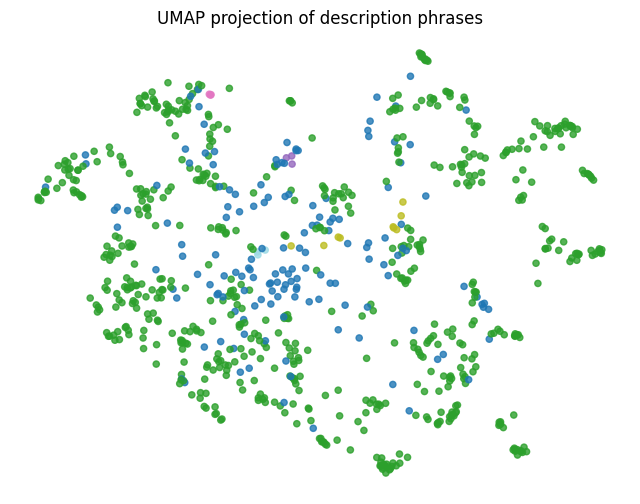

In [68]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)

emb_2d = reducer.fit_transform(phrase_embeddings)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    emb_2d[:,0],
    emb_2d[:,1],
    c=final_labels,
    cmap="tab20",
    s=20,
    alpha=0.8
)
plt.title("UMAP projection of description phrases")
plt.axis("off")
plt.show()

# 2 very dominant clusters

In [69]:
def inspect_cluster(cid, n=20):
    examples = df_task2[df_task2["cluster_id"] == cid]["phrase"].head(n)
    print(f"CLUSTER {cid} — EXAMPLES:")
    for p in examples:
        print("  -", p)
for cid in sorted(df_task2["cluster_id"].unique()):
    if cid == -1:
        continue
    inspect_cluster(cid, n=20)
    print()


CLUSTER 0 — EXAMPLES:
  - gunman
  - opened fire
  - stealing lives
  - devastating a nation
  - Deadly shooting
  - Texas elementary school
  - help investigators
  - Nineteen children
  - two adults
  - intense scrutiny
  - shooting at an elementary school
  - 21 dead
  - 18-year-old man
  - also dead
  - active shooter
  - elementary school
  - law enforcement
  - on site
  - Texas Republican Gov. Greg Abbott
  - mass school shooting

CLUSTER 1 — EXAMPLES:
  - making it political
  - making it political
  - selfish politics
  - national political debate

CLUSTER 2 — EXAMPLES:
  - former FBI assistant director
  - Former FBI deputy assistant director
  - former FBI deputy assistant director
  - former FBI deputy assistant director

CLUSTER 3 — EXAMPLES:
  - less than eight minutes
  - over an hour
  - over an hour
  - first minutes
  - subdued start
  - about 80 miles west
  - over an hour
  - over an hour
  - first minutes
  - Less than 15 minutes
  - set to begin
  - first several 

In [70]:
cluster_labels = {
    0: "Violent events and shooter actions",
    1: "Politics",
    2: "Law enforcement",
    3: "Timeline references",
    4: "Standoff references"
}

Document (max 300 words) explaining your embedding choice and hyperparameter tuning process

SBERT embeddings were chosen to represent each descriptive phrase as a single semantic vector. One reason is because it is good at capturing multi-word expressions like as “opened fire” or “engaged in a standoff.” SBERT directly learns sentence-level similarity with cosine distance and preserves short contextual meaning, making it a good fit for news articles phrases. This embedding model was also computationally efficient and avoided requiring pooling.

DBSCAN hyperparameters were tuned using a grid search over epsilon values ranging from 0.3 to 0.6 and min_samples ranging from 3 to 8. Each configuration was evaluated based on the number of clusters formed and the proportion of phrases labeled as noise. Very small epsilon values caused excessive many small clusters and a high noise rate. Larger epsilon values collapsed almost all phrases into one group, removing the distinction ability. eps=0.5 and min_samples=3 produced 5 good clusters and a low noise proportion, allowing similar phrases to group naturally without high interpretability.

In [71]:
save_path = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task3_phrases_with_clusters.csv"
df_task2.to_csv(save_path, index=False)

# Task 4: Manual Cluster Evaluation

In [ ]:
# in case you want to start from here
from google.colab import drive
drive.mount('/content/drive')
pth = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task3_phrases_with_clusters.csv"
df_task2 = pd.read_csv(pth)

Clusters: 5

Noise fraction: 0.18030842230130487
Lexical coherence: Do items share similar words or morphological patterns?

Semantic coherence: Do items convey similar meanings or framings?


GPT:
Each DBSCAN cluster was manually inspected for lexical coherence, semantic coherence, and purity. Cluster 0 showed strong lexical similarity and thematic cohesion. Phrases referenced mass school shootings, casualty counts, law enforcement presence, and on-site tragedy framing. Surface wording was consistent and multiword phrases were conceptually aligned, which indicated high semantic coherence and low impurity. Cluster 1 captured political rhetoric and debate framing. Although the individual phrases were short, their wording and meaning were tightly related, suggesting strong coherence. Cluster 2 contained references to law enforcement expert sources (e.g., former FBI officials), which was lexically uniform and semantically coherent. Cluster 3 consisted of temporal and situational references (e.g., elapsed minutes, geographic positions, or logistical sequencing). Although some phrases described spatial positioning rather than time, the conceptual grouping remained stable enough to justify a single cluster. Cluster 4 captured confrontation and standoff language between the shooter and law enforcement, and its lexical structure was highly consistent.

Across clusters, purity was generally high, with only a small number of borderline items. Most outliers belonged to the DBSCAN noise group instead of distorting meaningful clusters. No major misclassifications were found that required splitting or merging. However, temporal and spatial elements in Cluster 3 could be further subdivided if more granularity were required, but this was not necessary for downstream analysis. Overall, the clusters were interpretable, internally coherent, and appropriate for cross-outlet statistical comparison.



More:
Cluster 0 is very large, which indicates a dense semantic region in the embedding space that captures the primary framing of school shootings, casualties, law enforcement presence, and on-site tragedy. Its size reflects natural semantic dominance in the news corpus rather than over-merging, since random or ambiguous phrases were kept out through DBSCAN’s noise mechanism.

The noise cluster (–1) includes 207 items that did not form stable neighborhoods, confirming that DBSCAN did not force dissimilar phrases into coherent clusters. This supports high purity in the main clusters.

Clusters 1, 2, 4 are small but semantically coherent (political framing, expert sourcing, law enforcement standoff). Their small size is expected because they describe specific subframes, not the main narrative.

Cluster 3 is moderate in size and represents temporal and situational phrasing, which appears less frequently but still forms a clear semantic neighborhood.


### Cluster interpretations
DBSCAN produced five interpretable clusters and a noise group. Cluster 0 was the dominant cluster, capturing violent events, shooter actions, and casualty descriptions. Its size reflects the natural topical density within the corpus rather than excessive merging. Cluster 1 reflected political rhetoric. Cluster 2 contained federal law-enforcement references (e.g., former FBI officials). Cluster 3 captured temporal and situational references, such as time elapsed and event sequence. Cluster 4 represented standoff language referencing armed confrontation between the shooter and police. Noise (cluster –1) contained ambiguous phrases that did not align with any of the clusters, which preserved purity in the main 5 clusters.

### Lexical coherence: Do items share similar words or morphological patterns?
Clusters exhibited strong lexical similarity. Cluster 0 consistently included multiword expressions describing shootings, victim counts, police presence, or site-specific tragedy. Cluster 1 centered on short political terms, while Cluster 2 consistently referred to federal law enforcement, specifically the FBI. Cluster 3 showed time related markers, and Cluster 4 showed repeated “standoff” phrasing. Their structure and word-choice patterns were overall consistent within clusters.

### Semantic coherence: Do items convey similar meanings or framings?
Clusters conveyed similar meanings. Cluster 0 captured mass school shootings, casualties, and law enforcement presence. Cluster 1 conveyed politicals and debate framing. Cluster 2 reflected FBI presence, while Cluster 3 highlighted event timing or sequencing. Cluster 4 represented armed standoff scenarios.

### Cluster purity: Are there obvious misclassifications?
Purity was generally high. Ambiguous or rare phrases were placed into the noise group (-1) rather than weakening cluster boundaries, as can be seen when inspecting the noise group examples below. No substantial misclassifications were observed that required splitting or merging, although Cluster 3 could be divided if finer temporal detail were needed. Overall, the five clusters demonstrated clean groupings, consistent semantic meaning, and stable purity.

In [72]:
# cluster sizes
df_task2.groupby("cluster_id")["phrase"].count().sort_values(ascending=False)

,phrase
cluster_id,
0,1436
-1,207
3,14
1,4
2,4
4,4


In [76]:
# taking a look at the noise cluster
inspect_cluster(-1, n=50)

CLUSTER -1 — EXAMPLES:
  - grim task
  - providing DNA swabs
  - Democrat Beto O'Rourke
  - press conference
  - latest entry
  - latest entry
  - few if any friends
  - few if any friends
  - personal background
  - personal background
  - mindset
  - plan
  - mindset
  - plan
  - incomprehensively
  - traveled to New York City
  - romantic jealousy
  - romantic jealousy
  - Kaitlin Marie Armstrong
  - Anna Moriah 'Mo' Wilson
  - Anna Moriah 'Mo' Wilson
  - arrest affidavit
  - Travis County District Court
  - able to enter
  - carrying a backpack
  - lives in Germany
  - lives in Germany
  - complained
  - annoying
  - right now
  - grim task
  - providing DNA swabs
  - Democrat Beto O'Rourke
  - press conference
  - lives in Germany
  - lives in Germany
  - complained
  - annoying
  - right now
  - political branches divided
  - path forward
  - provide updates
  - postponed the launch
  - postponing the launch
  - Balenciaga collection
  - flashing red
  - flashing red
  - called o

# Task 5: Cross-Outlet Frequency Analysis

In [4]:
# in case you want to start from
from google.colab import drive
drive.mount('/content/drive')

pth = "/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task3_phrases_with_clusters.csv"
df_task2 = pd.read_csv(pth)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
freq_table = (
    df_task2
    .groupby(["outlet", "entity_type", "cluster_id"])
    .size()
    .reset_index(name="count")
)

freq_table.head()

,outlet,entity_type,cluster_id,count
0,cnn,shooter,-1,20
1,cnn,shooter,0,208
2,cnn,victim,-1,25
3,cnn,victim,0,220
4,cnn,victim,1,2


In [6]:
prop_table = (
    freq_table
    .assign(
        proportion=lambda x: x["count"] /
        x.groupby(["outlet", "entity_type"])["count"].transform("sum")
    )
)

prop_table.head()

,outlet,entity_type,cluster_id,count,proportion
0,cnn,shooter,-1,20,0.087719
1,cnn,shooter,0,208,0.912281
2,cnn,victim,-1,25,0.101215
3,cnn,victim,0,220,0.890688
4,cnn,victim,1,2,0.008097


In [7]:
freq_pivot = freq_table.pivot_table(
    index=["outlet", "entity_type"],
    columns="cluster_id",
    values="count",
    fill_value=0
)

freq_pivot


cluster_id            -1      0    1    2    3    4
outlet entity_type                                 
cnn    shooter      20.0  208.0  0.0  0.0  0.0  0.0
       victim       25.0  220.0  2.0  0.0  0.0  0.0
fox    shooter      10.0  163.0  0.0  3.0  0.0  0.0
       victim       25.0  187.0  1.0  1.0  1.0  0.0
nyt    shooter      21.0  107.0  0.0  0.0  3.0  2.0
       victim       37.0  212.0  1.0  0.0  5.0  2.0
wsj    shooter      37.0  170.0  0.0  0.0  3.0  0.0
       victim       32.0  169.0  0.0  0.0  2.0  0.0

In [8]:
prop_pivot = prop_table.pivot_table(
    index=["outlet", "entity_type"],
    columns="cluster_id",
    values="proportion",
    fill_value=0
)

prop_pivot


cluster_id                -1         0         1         2         3         4
outlet entity_type                                                            
cnn    shooter      0.087719  0.912281  0.000000  0.000000  0.000000  0.000000
       victim       0.101215  0.890688  0.008097  0.000000  0.000000  0.000000
fox    shooter      0.056818  0.926136  0.000000  0.017045  0.000000  0.000000
       victim       0.116279  0.869767  0.004651  0.004651  0.004651  0.000000
nyt    shooter      0.157895  0.804511  0.000000  0.000000  0.022556  0.015038
       victim       0.143969  0.824903  0.003891  0.000000  0.019455  0.007782
wsj    shooter      0.176190  0.809524  0.000000  0.000000  0.014286  0.000000
       victim       0.157635  0.832512  0.000000  0.000000  0.009852  0.000000

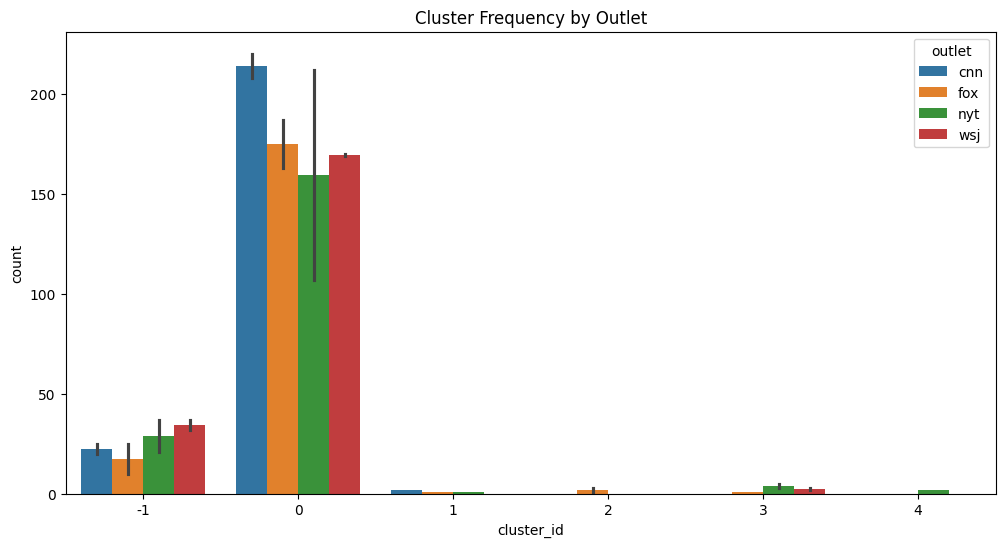

In [9]:
# compares outlets within each cluster
plt.figure(figsize=(12,6))
sns.barplot(
    data=freq_table,
    x="cluster_id",
    y="count",
    hue="outlet"
)
plt.title("Cluster Frequency by Outlet")
plt.show()


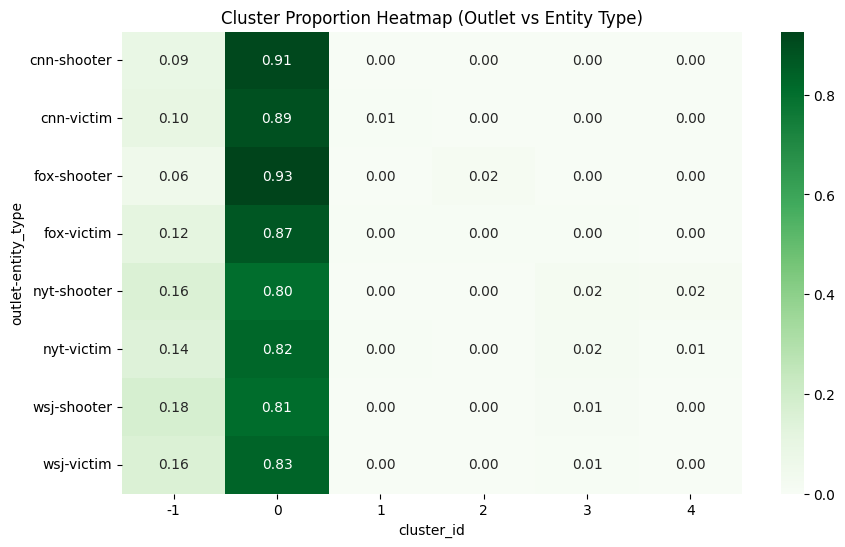

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(prop_pivot, annot=True, cmap="Greens", fmt=".2f")
plt.title("Cluster Proportion Heatmap (Outlet vs Entity Type)")
plt.show()

In [13]:
freq_pivot.to_csv("/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task5_cluster_frequency.csv")
prop_pivot.to_csv("/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task5_cluster_proportions.csv")

# Task 6: Statistical Hypothesis Testing

The top 3 clusters for both entity types are Cluster 0 (Violent events), Cluster -1 (Noise), and Cluster 3 (Timeline references).

*Null hypotheses (H0):*

The proportion of shooter descriptions labeled as Cluster 0 does not differ across CNN, Fox News, NYT, and WSJ.

The proportion of shooter descriptions labeled as Cluster -1 does not differ across CNN, Fox News, NYT, and WSJ.

The proportion of shooter descriptions labeled as Cluster 3 does not differ across CNN, Fox News, NYT, and WSJ.

In [11]:
from scipy.stats import chi2_contingency

def chi_square_for_cluster(freq_pivot, cluster_id, entity_type):
    # Filter only the rows belonging to this entity type
    filtered = freq_pivot.loc[(slice(None), entity_type), :]

    counts = filtered[cluster_id]

    contingency = counts.values.reshape(4, 1)  # 4 outlets

    # Compare this cluster vs all other clusters combined
    other_cts = filtered.sum(axis=1) - counts
    contingency = pd.DataFrame({
        "cluster_x": counts,
        "other_clusters": other_cts
    })

    chi2, p, dof, expected = chi2_contingency(contingency)

    return chi2, p, contingency, expected

# Run for shooter entity
clusters_to_test = [-1, 0, 3]

results = {}

for cid in clusters_to_test:
    chi2, p, contingency, expected = chi_square_for_cluster(freq_pivot, cid, "shooter")
    results[f"shooter_cluster_{cid}"] = (chi2, p, contingency, expected)

# Run for victim entity
for cid in clusters_to_test:
    chi2, p, contingency, expected = chi_square_for_cluster(freq_pivot, cid, "victim")
    results[f"victim_cluster_{cid}"] = (chi2, p, contingency, expected)

results


{'shooter_cluster_-1': (np.float64(17.229502989287326),
  np.float64(0.0006339355416480364),
                      cluster_x  other_clusters
  outlet entity_type                           
  cnn    shooter           20.0           208.0
  fox    shooter           10.0           166.0
  nyt    shooter           21.0           112.0
  wsj    shooter           37.0           173.0,
  array([[ 26.85943775, 201.14056225],
         [ 20.73360107, 155.26639893],
         [ 15.66800535, 117.33199465],
         [ 24.73895582, 185.26104418]])),
 'shooter_cluster_0': (np.float64(19.97014717046864),
  np.float64(0.0001721777131384399),
                      cluster_x  other_clusters
  outlet entity_type                           
  cnn    shooter          208.0            20.0
  fox    shooter          163.0            13.0
  nyt    shooter          107.0            26.0
  wsj    shooter          170.0            40.0,
  array([[197.78313253,  30.21686747],
         [152.6746988 ,  23.3253012 ],
 

| Cluster  | Entity | p-value | Significance |
| -------- | ------- |------- |------- |
| Cluster 0 | Shooter | 0.00017 | Highly significant |
| Cluster 3 | Shooter | 0.0498 | Significant (just under 0.05) |
| Cluster -1 (noise) | Shooter | 0.00063 | Highly significant |
| Cluster 0 | Victim | 0.1322 | Not significant |
| Cluster 3 | Victim | 0.1082 | Not significant |
| Cluster -1 (noise) | Victim | 0.2615 | Not significant |

For shooter descriptions, all three clusters produced statistically significant results, meaning we reject the null hypothesis. These findings indicate that outlets differ in their emphasis on violent-event framing, timeline details, and the amount of ambiguous or noisy phrasing. From the results, it can be seen that NYT and WSJ significantly overused timeline and situational references, while CNN and Fox underused this framing. In contrast, CNN and Fox overused violent-event shooter framing (Cluster 0), whereas NYT and WSJ used this frame less than expected. NYT and WSJ showed higher than expected noise, suggesting more diverse descriptive phrasing. CNN and Fox exhibited lower noise, indicating more repetitive language.

For victim descriptions, none of the clusters yielded significant results (all p > 0.10). Thus we can accept the null hypothesis for victime entities, suggesting that outlets portray victims in very similar ways.

Overall, the results show that outlet variation in descriptive reporting is more pronounced for shooters than for victims.


In [14]:
def convert(o):
    # Convert numpy types to Python types for json
    if isinstance(o, (np.integer,)):
        return int(o)
    if isinstance(o, (np.floating,)):
        return float(o)
    if isinstance(o, np.ndarray):
        return o.tolist()
    return o
json_results = {
    name: {
        "chi2": float(chi2),
        "p_value": float(p),
        "observed": contingency.values.tolist(),
        "outlets": list(contingency.index.get_level_values("outlet")),
        "expected": expected.tolist(),
    }
    for name, (chi2, p, contingency, expected) in results.items()
}

with open("/content/drive/MyDrive/Colab Notebooks/nlp_hw5/task6_chi_square_results.json", "w") as f:
    json.dump(json_results, f, default=convert, indent=2)